In [33]:
import torch
import networkx as nx
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from sklearn.metrics import r2_score 
import time 
from matplotlib import pyplot as plt 
import copy
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sbn 
import pickle as pkl 

import sys 
sys.path.append('../')

from src.models.GSNN import GSNN
from src.data.LincsDataset import LincsDataset
from src.models import utils 

from src.uncertainty.DistNN import DistNN
from src.uncertainty.NNEnsemble import NNEnsemble
from src.uncertainty.utils import root_mean_squared_picp_error, compute_picp, compute_ECE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single Agent performance (PRISM)

In [1]:
def load_prism_activations(root, eps=1e-3):

    ensemble = torch.load(f'{root}/ViabNNEnsemble.pt')
    activations_dict = pkl.load(open(f'{root}/activations_dict.pkl', 'rb'))

    y_train = activations_dict['train']['y_viab_target']
    x_train = activations_dict['train']['activations']
    train_sigids = activations_dict['train']['sig_ids']

    y_val = activations_dict['val']['y_viab_target']
    x_val = activations_dict['val']['activations']
    val_sigids = activations_dict['val']['sig_ids']

    y_test = activations_dict['test']['y_viab_target']
    x_test = activations_dict['test']['activations']
    test_sigids = activations_dict['test']['sig_ids']

    y_train = torch.clamp(y_train, eps, 1-eps)
    y_test = torch.clamp(y_test, eps, 1-eps)
    y_val = torch.clamp(y_val, eps, 1-eps)

    yhat_train = ensemble(x_train)
    yhat_test = ensemble(x_test)
    yhat_val = ensemble(x_val)

    return {'x':{'train':x_train,
                 'test':x_test,
                 'val':x_val}, 
            'y':{'train':y_train,
                 'test':y_test,
                 'val':y_val},
            'yhat':{'train':yhat_train,
                 'test':yhat_test,
                 'val':yhat_val},
            'sig_ids':{'train':train_sigids,
                       'test':test_sigids,
                       'val':val_sigids},
            'f_viab':ensemble}

In [3]:
nn_dict = load_prism_activations(root='../output/exp1/FOLD-1/NN/872dcbb7-e641-47af-ba26-8ea820c583d6/', eps=1e-3)
gsnn_dict = load_prism_activations(root='../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/', eps=1e-3)

In [39]:
print('train set size:', len(gsnn_dict['y']['train']))
print('test set size:', len(gsnn_dict['y']['test']))
print('val set size:', len(gsnn_dict['y']['val']))

train set size: 115215
test set size: 3044
val set size: 3003


In [44]:
prism_ids = np.load('../output/exp1/proc/prism_ids.npy', allow_pickle=True)
prism_cells = np.unique([x.split('::')[0] for x in prism_ids])
prism_drugs = np.unique([x.split('::')[1] for x in prism_ids])
print('# PRISM obs.', len(prism_ids))
print('# PRISM cell lines', len(prism_cells))
print('# PRISM drugs', len(prism_drugs))

# PRISM obs. 115215
# PRISM cell lines 62
# PRISM drugs 305


In [43]:
prism_ids[0]

'MCF7::BRD-A00147595::2.5'

In [37]:
partition = 'test'

gsnn_test_mse = torch.mean((nn_dict['yhat'][partition].mean - nn_dict['y'][partition])**2).item()
nn_test_mse = torch.mean((gsnn_dict['yhat'][partition].mean - gsnn_dict['y'][partition])**2).item()
rand_test_mse = torch.mean((torch.rand_like(gsnn_dict['yhat'][partition].mean) - gsnn_dict['y'][partition])**2).item()

gsnn_test_r = np.corrcoef(gsnn_dict['yhat'][partition].mean.detach(), gsnn_dict['y'][partition].detach())[0,1]
nn_test_r = np.corrcoef(nn_dict['yhat'][partition].mean.detach(), nn_dict['y'][partition].detach())[0,1]
rand_test_r = np.corrcoef(torch.rand_like(gsnn_dict['yhat'][partition].mean), nn_dict['y'][partition].detach())[0,1]

gsnn_test_r2 = r2_score(gsnn_dict['yhat'][partition].mean.detach(), gsnn_dict['y'][partition].detach())
nn_test_r2 = r2_score(nn_dict['yhat'][partition].mean.detach(), nn_dict['y'][partition].detach())

gsnn_ece = compute_ECE(gsnn_dict['yhat'][partition], gsnn_dict['y'][partition], num_intervals=10)
nn_ece = compute_ECE(nn_dict['yhat'][partition], nn_dict['y'][partition], num_intervals=10)

print(f'GSNN MSE ({partition})', gsnn_test_mse)
print(f'NN MSE ({partition})', nn_test_mse)
print(f'rand MSE ({partition})', rand_test_mse)
print()
print(f'GSNN r. ({partition})', gsnn_test_r)
print(f'NN r ({partition})', nn_test_r)
print(f'rand r ({partition})', rand_test_r)
print()
print(f'GSNN r2. ({partition})', gsnn_test_r2)
print(f'NN r2 ({partition})', nn_test_r2)
print()
print(f'GSNN ECE. ({partition})', gsnn_ece)
print(f'NN ECE ({partition})', nn_ece)

GSNN MSE (test) 0.016935007646679878
NN MSE (test) 0.02145499549806118
rand MSE (test) 0.26319578289985657

GSNN r. (test) 0.8712785938994053
NN r (test) 0.8999564739827233
rand r (test) -0.02413593562245666

GSNN r2. (test) 0.6329769142983359
NN r2 (test) 0.7236675744407486

GSNN ECE. (test) 0.11123522222042084
NN ECE (test) 0.10857424587011337


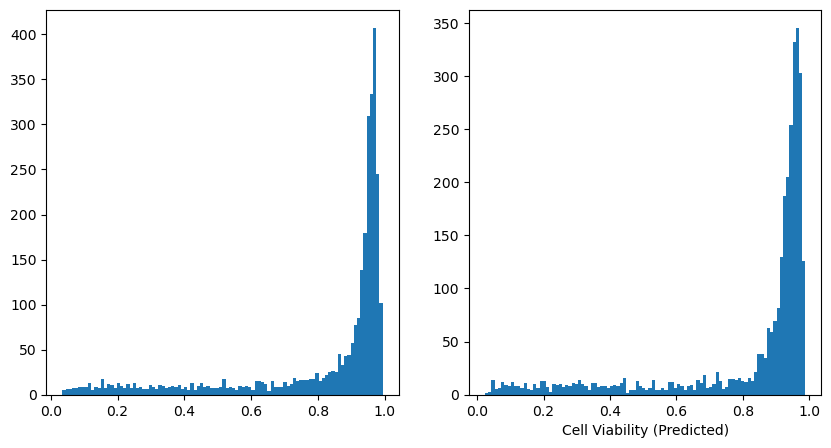

In [8]:
f,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].hist(nn_dict['yhat']['test'].mean.detach(), bins=100)
axes[1].hist(gsnn_dict['yhat']['test'].mean.detach(), bins=100)
plt.xlabel('Cell Viability (Predicted)')
plt.show()

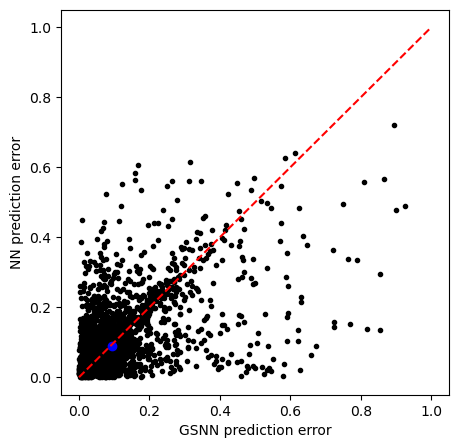

In [19]:
f,axes=plt.subplots(1,1,figsize=(5,5))
axes.plot(np.abs(gsnn_dict['yhat']['test'].mean.detach() - gsnn_dict['y']['test']) , np.abs(nn_dict['yhat']['test'].mean.detach() - nn_dict['y']['test']), 'k.')
axes.plot(np.abs(gsnn_dict['yhat']['test'].mean.detach() - gsnn_dict['y']['test']).mean() , np.abs(nn_dict['yhat']['test'].mean.detach() - nn_dict['y']['test']).mean(), 'bo')
axes.plot((0,1), (0,1), 'r--')
plt.xlabel('GSNN prediction error')
plt.ylabel('NN prediction error')
plt.show()

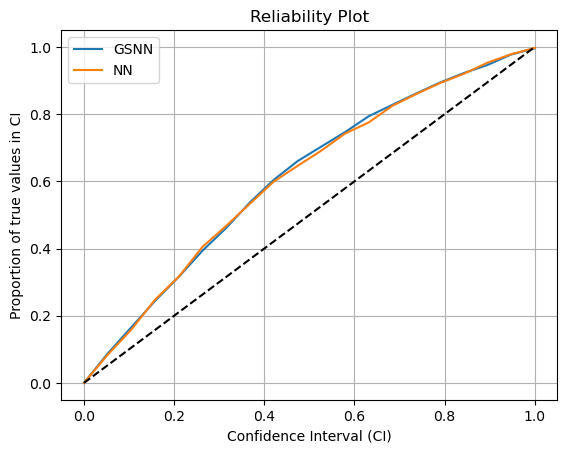

In [24]:
plt.figure()

alphas = torch.linspace(0,1,20)
N = 100 # num. iters to compute prediction intervals 
plt.plot(1-alphas, [compute_picp(gsnn_dict['yhat']['test'], gsnn_dict['y']['test'].detach(), alpha=alpha, N=N) for alpha in alphas], label='GSNN')
plt.plot(1-alphas, [compute_picp(nn_dict['yhat']['test'], nn_dict['y']['test'].detach(), alpha=alpha, N=N) for alpha in alphas], label='NN')
#for model in ensemble.models: 
#    _pred_test = model(x_test)
#    plt.plot(1-alphas, [compute_picp(_pred_test, y_test, alpha=alpha) for alpha in alphas], 'r--')
plt.plot((0,1), (0,1), 'k--')
plt.xlabel('Confidence Interval (CI)')
plt.ylabel('Proportion of true values in CI')
plt.grid()
plt.title('Reliability Plot')
plt.legend()
plt.show()

0.277284070498183


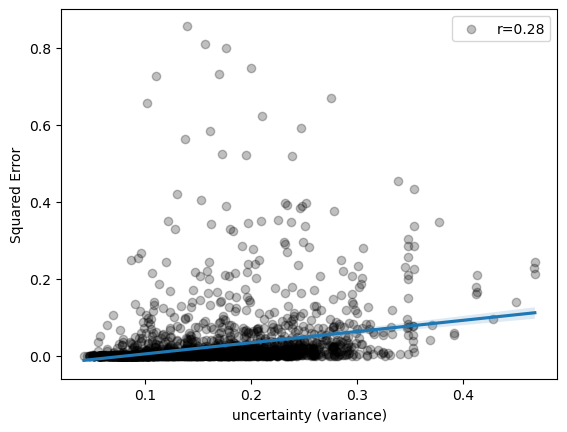

In [16]:
err = (pred_test.mean - y_test)**2
yhat_sigma_test = pred_test.variance**(0.5)

print(np.corrcoef(yhat_sigma_test.detach().cpu().numpy(), err.detach().cpu().numpy())[0,1])
plt.figure()
sbn.regplot(x=yhat_sigma_test.detach().cpu().numpy(), y=err.detach().cpu().numpy(), scatter_kws={'color':'k', 'alpha':0.25}, label=f'r={np.corrcoef(yhat_sigma_test.detach().cpu().numpy(), err.detach().cpu().numpy())[0,1]:.2f}')
plt.xlabel('uncertainty (variance)')
plt.ylabel('Squared Error')
plt.legend()
plt.show() 

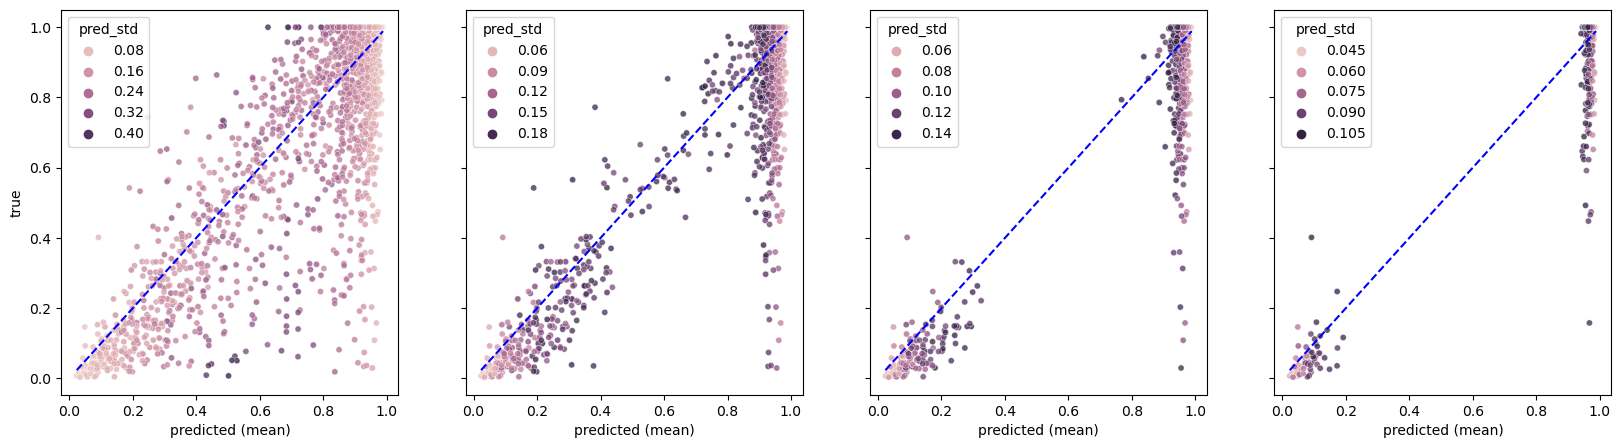

In [17]:
res = pd.DataFrame({'pred_mean': pred_test.mean.detach().cpu(), 'pred_std':pred_test.variance.detach().cpu()**(0.5), 'y_true':y_test.detach().cpu()})
xmin = res.pred_mean.min()
xmax = res.pred_mean.max()


f, axes = plt.subplots(1,4, figsize=(20,5), sharey=True)
sbn.scatterplot(x='pred_mean', y='y_true', hue='pred_std', data=res, s=20, alpha=0.75, ax=axes.flat[0]) 
axes.flat[0].plot((xmin, xmax), (xmin, xmax), 'b--')
axes.flat[0].set_xlabel('predicted (mean)')
axes.flat[0].set_ylabel('true')

sbn.scatterplot(x='pred_mean', y='y_true', hue='pred_std', data=res[lambda x: x.pred_std < np.quantile(x.pred_std, q = 0.75)], s=20, alpha=0.75, ax=axes.flat[1]) 
axes.flat[1].plot((xmin, xmax), (xmin, xmax), 'b--')
axes.flat[1].set_xlabel('predicted (mean)')
axes.flat[1].set_ylabel('true')

sbn.scatterplot(x='pred_mean', y='y_true', hue='pred_std', data=res[lambda x: x.pred_std < np.quantile(x.pred_std, q = 0.5)], s=20, alpha=0.75, ax=axes.flat[2]) 
axes.flat[2].plot((xmin, xmax), (xmin, xmax), 'b--')
axes.flat[2].set_xlabel('predicted (mean)')
axes.flat[2].set_ylabel('true')

sbn.scatterplot(x='pred_mean', y='y_true', hue='pred_std', data=res[lambda x: x.pred_std < np.quantile(x.pred_std, q = 0.25)], s=20, alpha=0.75, ax=axes.flat[3]) 
axes.flat[3].plot((xmin, xmax), (xmin, xmax), 'b--')
axes.flat[3].set_xlabel('predicted (mean)')
axes.flat[3].set_ylabel('true')

#for i,row in res.iterrows(): 
#    if np.abs(row.pred_mean - row.y_true) > 0.5: 
#        plt.plot((row.pred_mean - 2*row.pred_std, row.pred_mean + 2*row.pred_std), (row.y_true, row.y_true), 'k-', alpha=0.5)

plt.show()

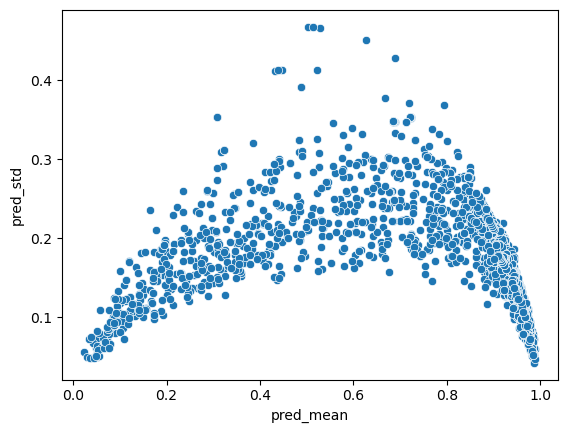

In [18]:
res = pd.DataFrame({'pred_mean': pred_test.mean.detach().cpu(), 'pred_std':pred_test.variance.detach().cpu()**(0.5), 'y_true':y_test.detach().cpu()})

plt.figure()
sbn.scatterplot(x='pred_mean', y='pred_std', data=res) 
plt.show()

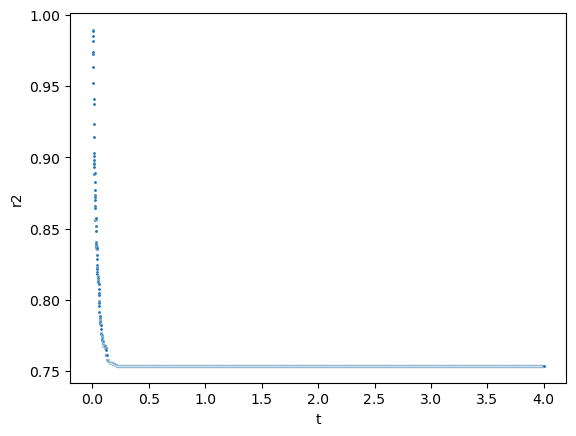

In [20]:
# confidence thresholds 
conf_res = {'t':[], 'r':[], 'r2':[], 'N':[]}
for t in np.linspace(0, 4., 5000): 
    mask = pred_test.variance.detach().cpu() <= t
    if torch.sum(mask).item() < 10: continue 
    yhat = pred_test.mean[mask]
    y = y_test[mask]
    conf_res['t'].append(t)
    conf_res['r'].append(np.corrcoef(yhat.detach(), y.detach())[0,1])
    conf_res['r2'].append(r2_score(y.detach().cpu().numpy(), yhat.detach().cpu().numpy()))
    conf_res['N'].append(torch.sum(mask).item()) 

conf_res= pd.DataFrame(conf_res)

plt.figure()
sbn.scatterplot(x='t', y='r2', data=conf_res, s=5)
plt.show()